In [1]:
# importer les packages
import pandas as pd
%pylab inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install xgboost

<b> Import du dataset nettoyé <b>

In [3]:
# Lire le dataframe nettoye df_6
df7=pd.read_csv('df6.csv')

In [4]:
df7.shape

(3309, 13)

In [5]:
df7.head()

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Latitude,Longitude,PropertyGFAParking,PropertyGFABuilding,Building_age,SiteEnergyUse,GHGEmissions,Log1p-SiteEnergyUse
0,NonResidential,Hotel,1.0,12.0,65.0,47.612190,-122.337997,0.0,88434.0,88.0,6981428.0,249.43,15.758764
1,NonResidential,Hotel,1.0,11.0,51.0,47.613106,-122.333358,15064.0,88502.0,19.0,8354235.0,263.51,15.938279
2,NonResidential,Hotel,1.0,41.0,18.0,47.613349,-122.337699,0.0,961990.0,46.0,73130656.0,2061.48,18.107758
3,NonResidential,Hotel,1.0,10.0,1.0,47.614216,-122.336609,0.0,61320.0,89.0,28229320.0,1936.34,17.155872
4,NonResidential,Hotel,1.0,18.0,67.0,47.613754,-122.340924,12460.0,107430.0,35.0,14829099.0,507.70,16.512102


In [6]:
df7.dtypes

BuildingType            object
PrimaryPropertyType     object
NumberofBuildings      float64
NumberofFloors         float64
ENERGYSTARScore        float64
Latitude               float64
Longitude              float64
PropertyGFAParking     float64
PropertyGFABuilding    float64
Building_age           float64
SiteEnergyUse          float64
GHGEmissions           float64
Log1p-SiteEnergyUse    float64
dtype: object

In [7]:
df7.isnull().sum()

BuildingType              0
PrimaryPropertyType       0
NumberofBuildings         0
NumberofFloors            8
ENERGYSTARScore        1098
Latitude                  0
Longitude                 0
PropertyGFAParking        0
PropertyGFABuilding       0
Building_age              0
SiteEnergyUse             0
GHGEmissions              0
Log1p-SiteEnergyUse       0
dtype: int64

<b> Prise en compte de la variable ENERGYSTARScore :<b>

In [8]:
df7.shape

(3309, 13)

In [9]:
# Suppression des lignes dont les targets sont des NaN
#---------------------------------------------------

df7 = df7.dropna(subset=['SiteEnergyUse', 'GHGEmissions','Log1p-SiteEnergyUse'])

In [10]:
df7.isna().sum().sum()

1106

In [11]:
df7.max()

BuildingType           SPS-District K-12
PrimaryPropertyType     Worship Facility
NumberofBuildings                  111.0
NumberofFloors                      99.0
ENERGYSTARScore                    100.0
Latitude                        47.73387
Longitude                     -122.25864
PropertyGFAParking              512608.0
PropertyGFABuilding            9320156.0
Building_age                       116.0
SiteEnergyUse                873923712.0
GHGEmissions                    16870.98
Log1p-SiteEnergyUse            20.588504
dtype: object

In [12]:
# log Transformation of variables 'PropertyGFAParking','PropertyGFABuilding'

logcols = ['PropertyGFAParking','PropertyGFABuilding']
df7[logcols] = np.log1p(df7[logcols])

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [13]:
df7.head()

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Latitude,Longitude,PropertyGFAParking,PropertyGFABuilding,Building_age,SiteEnergyUse,GHGEmissions,Log1p-SiteEnergyUse
0,NonResidential,Hotel,1.0,12.0,65.0,47.612190,-122.337997,0.000000,11.390023,88.0,6981428.0,249.43,15.758764
1,NonResidential,Hotel,1.0,11.0,51.0,47.613106,-122.333358,9.620129,11.390792,19.0,8354235.0,263.51,15.938279
2,NonResidential,Hotel,1.0,41.0,18.0,47.613349,-122.337699,0.000000,13.776760,46.0,73130656.0,2061.48,18.107758
3,NonResidential,Hotel,1.0,10.0,1.0,47.614216,-122.336609,0.000000,11.023878,89.0,28229320.0,1936.34,17.155872
4,NonResidential,Hotel,1.0,18.0,67.0,47.613754,-122.340924,9.430359,11.584604,35.0,14829099.0,507.70,16.512102


<b> Matrice X, Vecteur y <b>

In [14]:
#X = df7.copy().drop(['SiteEnergyUse', 'GHGEmissions' , 'Log1p-SiteEnergyUse'], axis=1)
X= df7.loc[:, ~df7.columns.isin(['SiteEnergyUse', 'GHGEmissions' , 'Log1p-SiteEnergyUse'])]

In [15]:
X.select_dtypes(['category','object']).nunique()

BuildingType            5
PrimaryPropertyType    30
dtype: int64

In [16]:
X.shape

(3309, 10)

<b> Variable target : SiteEnergyUse(kBtu) <b>

In [17]:
y=df7[['SiteEnergyUse']]

In [18]:
y.shape

(3309, 1)

In [19]:
y.max()

SiteEnergyUse    873923712.0
dtype: float64

In [20]:
categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(['int32','float64']).columns

In [21]:
numerical_columns

Index(['NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore', 'Latitude',
       'Longitude', 'PropertyGFAParking', 'PropertyGFABuilding',
       'Building_age'],
      dtype='object')

In [22]:
categorical_columns

Index(['BuildingType', 'PrimaryPropertyType'], dtype='object')

In [23]:
type(X[numerical_columns])

pandas.core.frame.DataFrame

In [24]:
X[numerical_columns].mean()

NumberofBuildings        1.117558
NumberofFloors           4.133293
ENERGYSTARScore         64.815920
Latitude                47.615967
Longitude             -122.333053
PropertyGFAParking       2.148082
PropertyGFABuilding     10.966765
Building_age            53.925053
dtype: float64

In [25]:
type(y)

pandas.core.frame.DataFrame

<b> Normalisation et OneHotEncoder <b>

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler


In [27]:
# Normalisation

ss=StandardScaler()
X_scale = ss.fit_transform(X[numerical_columns].values)
X_scale[:3,:]

array([[-0.05291004,  1.19664579,  0.00644911, -0.07861362, -0.20182857,
        -0.50399295,  0.47018026,  1.04123119],
       [-0.05291004,  1.04453058, -0.48403157, -0.05955631, -0.012449  ,
         1.75312652,  0.4710341 , -1.06720795],
       [-0.05291004,  5.60798687, -1.64016458, -0.05449548, -0.18966551,
        -0.50399295,  3.12150799, -0.24216655]])

In [28]:
X_scaled = pd.DataFrame(X_scale, index=X[numerical_columns].index, columns=X[numerical_columns].columns)
X_scaled.head(5)

,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Latitude,Longitude,PropertyGFAParking,PropertyGFABuilding,Building_age
0,-0.05291,1.196646,0.006449,-0.078614,-0.201829,-0.503993,0.470180,1.041231
1,-0.05291,1.044531,-0.484032,-0.059556,-0.012449,1.753127,0.471034,-1.067208
2,-0.05291,5.607987,-1.640165,-0.054495,-0.189666,-0.503993,3.121508,-0.242167
3,-0.05291,0.892415,-2.235748,-0.036452,-0.145154,-0.503993,0.063444,1.071788
4,-0.05291,2.109337,0.076518,-0.046057,-0.321270,1.708602,0.686332,-0.578295


In [29]:
X_scaled.mean()

NumberofBuildings      6.240140e-16
NumberofFloors         4.347393e-16
ENERGYSTARScore       -4.368584e-18
Latitude               1.225771e-13
Longitude              3.238708e-13
PropertyGFAParking     5.064470e-16
PropertyGFABuilding    8.909985e-17
Building_age          -1.480297e-16
dtype: float64

In [30]:
type(X_scaled)

pandas.core.frame.DataFrame

In [31]:
# Convert the dataframe X_scaled to np.array 
X_scaled=X_scaled.to_numpy()

In [32]:
type(X_scaled)

numpy.ndarray

In [33]:
from sklearn.preprocessing import OneHotEncoder



ohe = OneHotEncoder(sparse=False)

# Encodage
X_encoded=ohe.fit_transform(X[categorical_columns])



In [34]:
X_encoded=X_encoded.reshape(X_encoded.shape)

In [35]:
type(X_encoded)

numpy.ndarray

In [36]:
#Concatenation
    
X = np.concatenate([X_scaled, X_encoded], axis=1)


In [37]:
X.shape

(3309, 43)

In [38]:
y.shape

(3309, 1)

In [39]:
type(X)

numpy.ndarray

In [40]:
#X.isna().sum()

In [41]:
# import the KNNimputer class

from sklearn.impute import KNNImputer

# create an object for KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")
X = imputer.fit_transform(X)


In [42]:
np.count_nonzero(np.isnan(X))

0

In [43]:
X.shape

(3309, 43)

In [44]:
type(X)

numpy.ndarray

In [45]:
y.shape

(3309, 1)

In [46]:
np.count_nonzero(np.isnan(y))

0

In [47]:
y.isna().sum()

SiteEnergyUse    0
dtype: int64

In [48]:
y.isna().sum().sum()

0

In [49]:
# Convert the dataframe y to np.array 
y=y.to_numpy()

In [50]:
type(y)

numpy.ndarray

In [51]:
y.shape

(3309, 1)

In [52]:
#y

In [53]:
np.amax(X)

49.45537833069115

In [54]:
np.max(y)

873923712.0

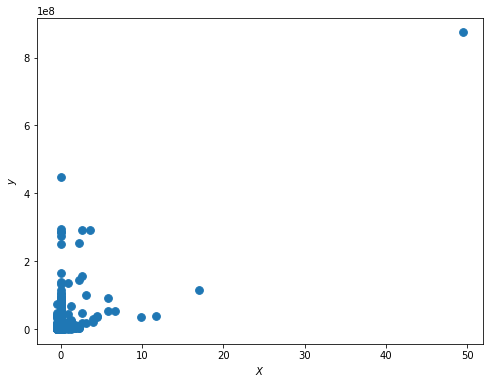

In [55]:
# Nuage de point representant les donnees 1ere colonne X[:,0],y
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],y,s=60)
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.show()

In [56]:
# Split the dataset into a training set and a test set.
#---------------------------------------------------------
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [57]:
np.max(X_train), np.max(X_test)

(49.45537833069115, 6.824908545737684)

In [58]:
 np.max(y_train), np.max(y_test)

(873923712.0, 284867168.0)

In [59]:
X_train[:,0]

array([-0.05291004, -0.05291004, -0.05291004, ..., -0.05291004,
       -0.05291004, -0.05291004])

In [60]:
X_train.shape

(2647, 43)

In [61]:
# Voir les NaN
X_train_nan = np.where(np.isnan(X_train))
print (X_train_nan)

(array([], dtype=int64), array([], dtype=int64))


In [62]:
y_train.shape

(2647, 1)

In [63]:
 X_test.shape

(662, 43)

In [64]:
# Voir les NaN
X_test_nan = np.where(np.isnan(X_test))
print (X_test_nan)

(array([], dtype=int64), array([], dtype=int64))


In [65]:
y_test.shape

(662, 1)

<b> Baseline <b>

In [66]:
#Create a baseline model using DummyRegressor.
#------------------------------------------------
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')

# fit it on the training set
dummy_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = dummy_reg.predict(X_test)

# calculate root mean squared error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# calculate coefficient of determination

R_dum_squared=r2_score(y_test, dummy_reg.predict(X_test))
print("Dummy RMSE:", rmse)
print("Dummy R2_dum:", R_dum_squared)

Dummy RMSE: 16429558.640352348
Dummy R2_dum: -0.0038069576893353663


In [67]:
results = pd.DataFrame({})

In [68]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Baseline'],
    'Score-R^2' : [r2_score(y_test, dummy_reg.predict(X_test))], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(y_test, dummy_reg.predict(X_test)))]}),
              ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/3283407470.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [69]:
from sklearn.linear_model import LinearRegression

# Create linear regression model 

regr = LinearRegression()
regr.fit(X_train, y_train)       # training the model on X_train, y_train
y_pred=regr.predict(X_test)      # predictions


In [70]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))               
print("\n------Linear regression--------")
#print("Weights: \n", regr.coef_)
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)               
print("R^2: %.3f" % r2_score(y_test, y_pred))


------Linear regression--------
MSE: 171478897814998.094
RMSE: 13094995.144
R^2: 0.362


In [71]:
X_test.shape

(662, 43)

In [72]:
y_test.shape

(662, 1)

<b> Cross validation <b>

In [73]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


#define cross-validation method to use
cv = KFold(n_splits=3, random_state=1, shuffle=True) 

#build multiple linear regression model
model = LinearRegression()

#use LOOCV to evaluate model
scores = cross_val_score(model, X_train, y_train, #scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view model
regr.fit(X_train, y_train)       # training the model on X_train, y_train


LinearRegression()

In [74]:
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr.fit(X_train, y_train)
    y_pred=regr.predict(X_test) 
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 SCORE:", r2_score(y_test, y_pred))
 

RMSE: 19035886.664513215
R2 SCORE: 0.34705205934536987
RMSE: 17423051.877868067
R2 SCORE: 0.3158754676849511
RMSE: 24394603.596977223
R2 SCORE: 0.34863656441597024


<b> Algorithmes linéaires <b>

In [75]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score,mean_absolute_error

In [76]:
from time import time

<b> Linear Regression, Ridge, Lasso et ElasticNet :<b>

In [77]:
Lr=LinearRegression()
Rd=Ridge(alpha=0.1)
La=Lasso(alpha=0.1)
EN=ElasticNet(random_state=0)

regressors = [Lr,Rd,La,EN]

In [78]:

for model in regressors:
    start = time()
    model.fit(X_train, y_train)   # creating the model
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)    # prediction 
    predict_time = time()-start   
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.3f" % rmse)               
    print("R^2: %.3f" % r2_score(y_test, y_pred))
    print()
    

LinearRegression()
	Training time: 0.002s
	Prediction time: 0.000s
MSE: 595096684653654.125
RMSE: 24394603.597
R^2: 0.349

Ridge(alpha=0.1)
	Training time: 0.003s
	Prediction time: 0.000s
MSE: 593545065466841.125
RMSE: 24362780.331
R^2: 0.350

Lasso(alpha=0.1)
	Training time: 0.078s
	Prediction time: 0.000s
MSE: 595096633721303.125
RMSE: 24394602.553
R^2: 0.349

ElasticNet(random_state=0)
	Training time: 0.003s
	Prediction time: 0.000s
MSE: 582044935665140.875
RMSE: 24125607.467
R^2: 0.363



/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+16, tolerance: 1.102e+14
  model = cd_fast.enet_coordinate_descent(


<b> GridSearchCV of the model :  <b>

In [79]:
from sklearn.model_selection import GridSearchCV


# GridSearch for ElasticNet
#----------------------------
from sklearn.linear_model import ElasticNet

# Fonction de coût du Elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.01,0.001,0.0001],
              "alpha": [0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coefficient qui multiplie le terme de pénalité
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}    #L1 ratio , si L1=1 (Lasso), L1= 0  (Ridge)

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                      verbose=0
                     )

elastic_grid.fit(X_train, y_train)
y_pred=elastic_grid.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e+17, tolerance: 7.052e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.736e+17, tolerance: 1.061e+16 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+16, tolerance: 9.047e+15
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+16, tolerance: 1.029e+16
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e+17, tolerance: 9.047e+15
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.538e+17, tolerance: 1.029e+16
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e+17, tolerance: 9.047e+13
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e+17, tolerance: 1.029e+14
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e+17, tolerance: 7.052e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+17, tolerance: 1.061e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+17, tolerance: 9.047e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.596e+17, tolerance: 1.029e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.430e+17, tolerance: 1.061e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.919e+17, tolerance: 6.984e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.378e+17, tolerance: 6.984e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.352e+17, tolerance: 9.047e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+17, tolerance: 6.984e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.504e+17, tolerance: 9.047e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

MSE: 569017280083093.125
RMSE: 23854083.090
R^2: 0.377


In [80]:
df_E = pd.DataFrame(elastic_grid.cv_results_).set_index('rank_test_score').sort_index()
df_E.shape

(180, 15)

In [81]:
df_E

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,
1,0.025326,0.002718,0.000160,0.000014,0.01,0.9,0.0001,"{'alpha': 0.01, 'l1_ratio': 0.9, 'tol': 0.0001}",-4.284439e+14,-5.659652e+13,-5.823280e+14,-2.481087e+14,-9.572052e+13,-2.822395e+14,1.991471e+14
2,0.026799,0.007074,0.000155,0.000005,0.01,0.9,0.001,"{'alpha': 0.01, 'l1_ratio': 0.9, 'tol': 0.001}",-4.284439e+14,-5.659652e+13,-5.823280e+14,-2.481087e+14,-9.572052e+13,-2.822395e+14,1.991471e+14
3,0.021801,0.003372,0.000149,0.000003,0.01,0.9,0.01,"{'alpha': 0.01, 'l1_ratio': 0.9, 'tol': 0.01}",-4.284439e+14,-5.659652e+13,-5.823280e+14,-2.481087e+14,-9.572052e+13,-2.822395e+14,1.991471e+14
4,0.069444,0.007716,0.000483,0.000079,0.001,0.0,0.01,"{'alpha': 0.001, 'l1_ratio': 0.0, 'tol': 0.01}",-4.284439e+14,-5.659652e+13,-5.823280e+14,-2.481087e+14,-9.572053e+13,-2.822395e+14,1.991471e+14
4,0.065459,0.009095,0.000385,0.000118,0.001,0.0,0.0001,"{'alpha': 0.001, 'l1_ratio': 0.0, 'tol': 0.0001}",-4.284439e+14,-5.659652e+13,-5.823280e+14,-2.481087e+14,-9.572053e+13,-2.822395e+14,1.991471e+14
4,0.059514,0.009176,0.000390,0.000072,0.001,0.0,0.001,"{'alpha': 0.001, 'l1_ratio': 0.0, 'tol': 0.001}",-4.284439e+14,-5.659652e+13,-5.823280e+14,-2.481087e+14,-9.572053e+13,-2.822395e+14,1.991471e+14
7,0.032195,0.005720,0.000201,0.000073,0.001,0.1,0.0001,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.0001}",-4.265382e+14,-5.709203e+13,-5.833765e+14,-2.478204e+14,-9.639539e+13,-2.822445e+14,1.989571e+14
8,0.036194,0.006142,0.000260,0.000167,0.001,0.1,0.001,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.001}",-4.265382e+14,-5.709203e+13,-5.833765e+14,-2.478204e+14,-9.639539e+13,-2.822445e+14,1.989571e+14
9,0.039682,0.006585,0.000279,0.000144,0.001,0.1,0.01,"{'alpha': 0.001, 'l1_ratio': 0.1, 'tol': 0.01}",-4.265382e+14,-5.709203e+13,-5.833765e+14,-2.478204e+14,-9.639539e+13,-2.822445e+14,1.989571e+14


In [82]:
elastic_grid.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.9)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Text(0, 0.5, 'mean_test_score')

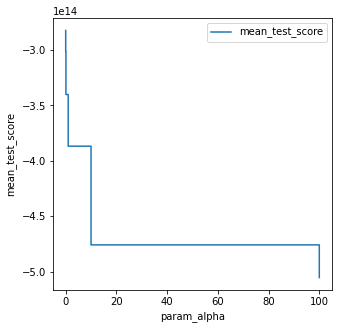

In [83]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
df_E.set_index("param_alpha")[["mean_test_score"]].plot(ax=ax)
ax.set_xlabel("param_alpha")
ax.set_ylabel("mean_test_score")

In [84]:

import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Elastic regression'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),
              ignore_index=True)



/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1489918071.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


<b> Support Vector Machine <b>

In [85]:

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVR

#----------------------------------------------------------------


parameters = {'gamma' : [1e-3, 1e-1,10], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1], #erreur tolérée par l'algorithme
              'C' : [0.01, 0.1, 10]} #parametre de régularisation


svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                   verbose=2
                     )

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)       
print("R^2: %.3f" % r2_score(y_test, y_pred))

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.001, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.01, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.1, gamma=10; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 945499607476778.875
RMSE: 30748977.340
R^2: -0.035


In [86]:
svm.best_params_

{'C': 10, 'epsilon': 0.001, 'gamma': 0.1}

In [87]:
#svm.cv_results_

In [88]:
df_svm = pd.DataFrame(svm.cv_results_).set_index('rank_test_score').sort_index()
df_svm.shape


(27, 15)

In [89]:
#df_svm

In [90]:
svm.best_estimator_

SVR(C=10, epsilon=0.001, gamma=0.1)

In [91]:

results = results.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(svm.predict(X_test), y_test))]}),
              ignore_index=True)



/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1720280300.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


<b> Algorithmes ensemblistes et nonlinéaires:  <b>

In [92]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor

<b> Random Forest Regressor, Gradient Boosting Regressor, Bagging Regressor,
    AdaBoost Regressor :<b>

In [93]:

RFR=RandomForestRegressor(max_depth=2, random_state=0)
#GBR=GradientBoostingRegressor(random_state=0)
GBR=GradientBoostingRegressor()
BR=BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)


regressors_ens=[RFR,GBR,BR]

#regressors_ens = [RandomForestRegressor()
#                  ,GradientBoostingRegressor(),BaggingRegressor()]

In [94]:
for model in regressors_ens:
    start = time()

    model.fit(X_train, y_train)   # creating the model
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)    # prediction 
    predict_time = time()-start    
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.3f" % rmse)               
    print("R^2: %.3f" % r2_score(y_test, y_pred))
    print()

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/2702254589.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)   # creating the model
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomForestRegressor(max_depth=2, random_state=0)
	Training time: 0.176s
	Prediction time: 0.005s
MSE: 642111518664961.125
RMSE: 25339919.468
R^2: 0.297

GradientBoostingRegressor()
	Training time: 0.287s
	Prediction time: 0.001s
MSE: 610657538966540.625
RMSE: 24711485.972
R^2: 0.332



/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(base_estimator=SVR(), random_state=0)
	Training time: 1.314s
	Prediction time: 2.507s
MSE: 946201650016068.750
RMSE: 30760390.928
R^2: -0.036



In [95]:
# GridSearchCV for Random Forest Regressor
#--------------------------------------------------------


parameters = {
    'n_estimators' : [10,50,100], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}

In [96]:
rfr_search = GridSearchCV(RFR,
                               param_grid = parameters,
                               #scoring='mean_squared_error',
                              verbose=2,
                               cv=5)

rfr_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.1s
[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=10; total time=   0.0s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=50; total time=   0.0s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.0s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.0s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.1s
[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.1s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


[CV] END max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.1s


GridSearchCV(cv=5, estimator=RandomForestRegressor(max_depth=2, random_state=0),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [10, 50, 100]},
             verbose=2)

In [97]:
y_pred=rfr_search.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

MSE: 619368218805882.125
RMSE: 24887109.491
R^2: 0.322


In [98]:
df_rf = pd.DataFrame(rfr_search.cv_results_).set_index('rank_test_score').sort_index()
df_rf.shape

(18, 15)

In [99]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Random Forest Regressor'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(rfr_search.predict(X_test), y_test))]}),
              ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/2263635398.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [100]:
rfr_search.best_params_

{'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 100}

In [101]:
rfr_search.best_estimator_

RandomForestRegressor(max_depth=2, min_samples_leaf=3, random_state=0)

In [102]:
rfr_search.best_estimator_.feature_importances_

array([0.        , 0.        , 0.05888939, 0.        , 0.09807906,
       0.        , 0.67477011, 0.        , 0.00282298, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16543846, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [103]:
# GridSearchCV of the best model : GradientBoostingRegressor
#----------------------------------------------------------
#GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [500,1000, 1500],
                  'max_depth'    : [6,8,10]
                 }


grid_GBR = GridSearchCV(estimator=GBR, 
                        param_grid = parameters, 
                        cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)  
y_pred = grid_GBR.predict(X_test) 
grid_GBR.score(X_test, y_test)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

0.35884450413573954

In [104]:
grid_GBR.best_estimator_

GradientBoostingRegressor(learning_rate=0.03, max_depth=6, n_estimators=500,
                          subsample=0.5)

In [105]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Gradient Boosting Regressor'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(grid_GBR.predict(X_test), y_test))]}),
              ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/4088207243.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [106]:
results

,Modèle,Score-R^2,Score_RMSE
0,Baseline,-0.003807,1.642956e+07
1,Elastic regression,0.377182,2.385408e+07
2,Support Vector Machine,-0.034897,3.074898e+07
3,Random Forest Regressor,0.322070,2.488711e+07
4,Gradient Boosting Regressor,0.358845,2.420270e+07


<b> Comparaison des modèles:<b>

 Nous comparons les modèles en termes de RMSE divisée par la moyenne de la valeur à prédire.

In [107]:
results['RMSE_%'] = results['Score_RMSE'].divide(y_test.mean())

In [108]:
results

,Modèle,Score-R^2,Score_RMSE,RMSE_%
0,Baseline,-0.003807,1.642956e+07,2.020647
1,Elastic regression,0.377182,2.385408e+07,2.933779
2,Support Vector Machine,-0.034897,3.074898e+07,3.781772
3,Random Forest Regressor,0.322070,2.488711e+07,3.060829
4,Gradient Boosting Regressor,0.358845,2.420270e+07,2.976654


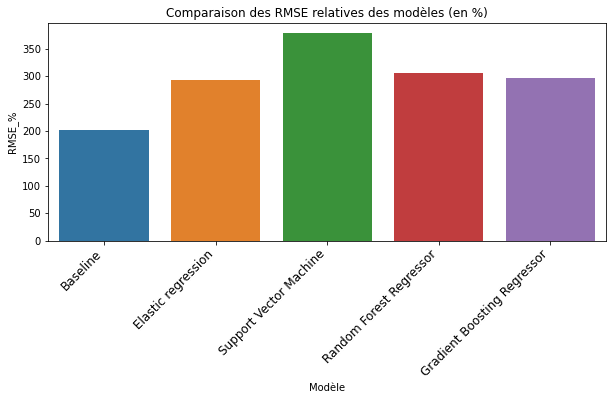

In [109]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des RMSE relatives des modèles (en %)')
chart = sns.barplot(x = results['Modèle'],
           y = results['RMSE_%']*100)
chart.set_xticklabels(labels = results['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

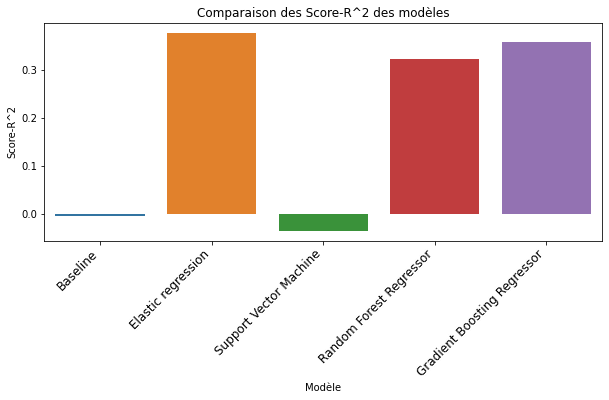

In [110]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des Score-R^2 des modèles')
chart = sns.barplot(x = results['Modèle'],
           y = results['Score-R^2'])
chart.set_xticklabels(labels = results['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

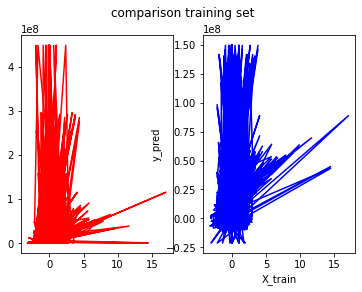

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('comparison training set')
ax1.plot(X_train, y_train, color = 'red')
plt.xlabel('X_train')
plt.ylabel('y_train')
ax2.plot(X_train, elastic_grid.predict(X_train), color = 'blue')
plt.xlabel('X_train')
plt.ylabel('y_pred')
plt.subplots_adjust(hspace = 0.5)
#fig.tight_layout()
plt.show()


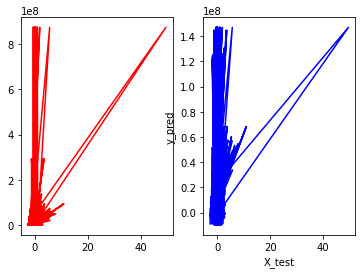

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('comparison test set')
ax1.plot(X_test, y_test, color = 'red')
plt.xlabel('X_test')
plt.ylabel('y_test')
ax2.plot(X_test, elastic_grid.predict(X_test), color = 'blue')
plt.xlabel('X_test')
plt.ylabel('y_pred')

plt.subplots_adjust(hspace = 1.5)
#fig.tight_layout()
plt.show()

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


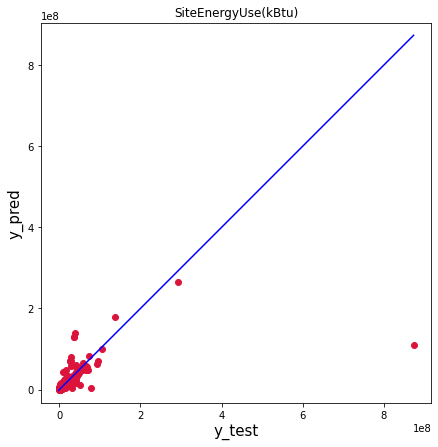

In [113]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_pred', fontsize=15)
plt.title('SiteEnergyUse(kBtu)')
plt.axis('equal')
plt.show()

In [114]:
# Sauvegarde des modèles pour SiteEnergyUse(kBtu)

dic_models_SEU = {
    'ElasticNet Regression': elastic_grid.best_estimator_,
    'Random Forest Regressor' : rfr_search.best_estimator_,
    'SVM' : svm.best_estimator_,
    'Gradient Boosting Regressor' : grid_GBR.best_estimator_,
}


In [115]:
model_name = ['ElasticNet Regression','Random Forest Regressor' ,'SVM', 'Gradient Boosting Regressor']
list_models = [dic_models_SEU['ElasticNet Regression'], dic_models_SEU['Random Forest Regressor'],
                 dic_models_SEU['SVM'],
                 dic_models_SEU['Gradient Boosting Regressor']
              ]

In [116]:
i=0
for model in list_models:
    print(model_name[i], ': ')
    i+=1
    %timeit model.predict(X_train)
    print('')

ElasticNet Regression : 
88.8 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

Random Forest Regressor : 
5.57 ms ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

SVM : 
713 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Gradient Boosting Regressor : 
15.3 ms ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



<b> Variable target : Log1p-SiteEnergyUse(kBtu) <b>

In [117]:
X.shape

(3309, 43)

In [118]:
y=df7['SiteEnergyUse']

In [119]:
from sklearn.compose import TransformedTargetRegressor

regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=regressor,func=np.log1p, inverse_func=np.expm1)
regr.fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

raw_target_regr = LinearRegression().fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))


R2 score: 0.49
R2 score: 0.35


<b> Linear Regression, Ridge, Lasso et ElasticNet :<b>

In [120]:
#regressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()]

In [121]:
regressors = [Lr,Rd,La,EN]

In [122]:
for model in regressors:
    start = time()
    model.fit(X_train, y_train)   # creating the model
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)    # prediction 
    predict_time = time()-start   
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.3f" % rmse)               
    print("R^2: %.3f" % r2_score(y_test, y_pred))
    print()

LinearRegression()
	Training time: 0.003s
	Prediction time: 0.000s
MSE: 595096684653654.125
RMSE: 24394603.597
R^2: 0.349

Ridge(alpha=0.1)
	Training time: 0.002s
	Prediction time: 0.000s
MSE: 593545065466841.125
RMSE: 24362780.331
R^2: 0.350

Lasso(alpha=0.1)
	Training time: 0.076s
	Prediction time: 0.000s
MSE: 595096633721303.125
RMSE: 24394602.553
R^2: 0.349

ElasticNet(random_state=0)
	Training time: 0.002s
	Prediction time: 0.000s
MSE: 582044935665140.875
RMSE: 24125607.467
R^2: 0.363



/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+16, tolerance: 1.102e+14
  model = cd_fast.enet_coordinate_descent(


In [123]:
# Fonction de coût du Elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.01,0.001,0.0001],
              "alpha": [0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coefficient qui multiplie le terme de pénalité
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}    #L1 ratio , si L1=1 (Lasso), L1= 0  (Ridge)

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                      verbose=0
                     )

elastic_grid.fit(X_train, y_train)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e+17, tolerance: 7.052e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.736e+17, tolerance: 1.061e+16 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+16, tolerance: 9.047e+15
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+16, tolerance: 1.029e+16
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e+17, tolerance: 9.047e+15
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.538e+17, tolerance: 1.029e+16
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e+17, tolerance: 9.047e+13
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e+17, tolerance: 1.029e+14
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e+17, tolerance: 6.984e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+17, tolerance: 9.047e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+17, tolerance: 9.047e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.596e+17, tolerance: 1.029e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.741e+17, tolerance: 9.047e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.280e+17, tolerance: 1.029e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.352e+17, tolerance: 9.047e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.955e+17, tolerance: 1.029e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.504e+17, tolerance: 9.047e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.124e+17, tolerance: 1.029e+15 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'tol': [0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error')

In [124]:
y_pred=elastic_grid.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

MSE: 569017280083093.125
RMSE: 23854083.090
R^2: 0.377


In [125]:
elastic_grid.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.9)

In [126]:
results = pd.DataFrame({})

In [127]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['ElasticNet Regression'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),
              ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1771279004.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [128]:
#GridSearchCV for Support Vector Machine

#----------------------------------------------------------------

parameters = {'gamma' : [1e-3, 1e-1,1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1], #erreur tolérée par l'algorithme
              'C' : [0.01, 0.1, 10]} #parametre de régularisation



svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                   verbose=2
                     )

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)       
print("R^2: %.3f" % r2_score(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.01, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.01, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.01, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.01, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.01, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.01, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.01, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=0.1, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=0.1, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=0.1, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=10, epsilon=0.001, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.001, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.001, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=10, epsilon=0.01, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=10, epsilon=0.01, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ........................C=10, epsilon=0.01, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=10, epsilon=0.1, gamma=0.001; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=10, epsilon=0.1, gamma=0.1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........................C=10, epsilon=0.1, gamma=1; total time=   0.3s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 945499607476778.875
RMSE: 30748977.340
R^2: -0.035


In [129]:

results = results.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(svm.predict(X_test), y_test))]}),
              ignore_index=True)



/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1720280300.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [130]:

regressors_ens=[RFR,GBR,BR]

In [131]:
# Algorithmes ensemblistes
#------------------------------------------------------
#regressors_ens = [RandomForestRegressor(),GradientBoostingRegressor(),BaggingRegressor()]

for model in regressors_ens:
    start = time()

    model.fit(X_train, y_train)   # creating the model
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)    # prediction 
    predict_time = time()-start    
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.3f" % rmse)               
    print("R^2: %.3f" % r2_score(y_test, y_pred))
    print()

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1157081362.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)   # creating the model
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomForestRegressor(max_depth=2, random_state=0)
	Training time: 0.177s
	Prediction time: 0.005s
MSE: 642111518664961.125
RMSE: 25339919.468
R^2: 0.297

GradientBoostingRegressor()
	Training time: 0.287s
	Prediction time: 0.001s
MSE: 608665269891742.000
RMSE: 24671142.452
R^2: 0.334



/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(base_estimator=SVR(), random_state=0)
	Training time: 1.327s
	Prediction time: 2.505s
MSE: 946201650016068.750
RMSE: 30760390.928
R^2: -0.036



<b> GridSearchCV : Gradient Boosting Regressor <b>

In [132]:
# GridSearchCV of the best model : GradientBoostingRegressor
#----------------------------------------------------------
#GBR = GradientBoostingRegressor()


parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8] 
                 }


grid_GBR = GridSearchCV(estimator=GBR, 
                        param_grid = parameters, 
                        cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)  
y_pred = grid_GBR.predict(X_test) 
grid_GBR.score(X_test, y_test)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

0.3773637976937003

In [133]:
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

MSE: 568850996994627.000
RMSE: 23850597.414
R^2: 0.377


In [134]:
import math
results = results.append(pd.DataFrame({
    'Modèle' : ['Gradient Boosting Regressor'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score_RMSE' : [math.sqrt(mean_squared_error(grid_GBR.predict(X_test), y_test))]}),
              ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/4088207243.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame({


In [135]:
results

,Modèle,Score-R^2,Score_RMSE
0,ElasticNet Regression,0.377182,2.385408e+07
1,Support Vector Machine,-0.034897,3.074898e+07
2,Gradient Boosting Regressor,0.377364,2.385060e+07


In [136]:
results['RMSE_%'] = results['Score_RMSE'].divide(y_test.mean())

In [137]:
results

,Modèle,Score-R^2,Score_RMSE,RMSE_%
0,ElasticNet Regression,0.377182,2.385408e+07,2.933779
1,Support Vector Machine,-0.034897,3.074898e+07,3.781772
2,Gradient Boosting Regressor,0.377364,2.385060e+07,2.933350


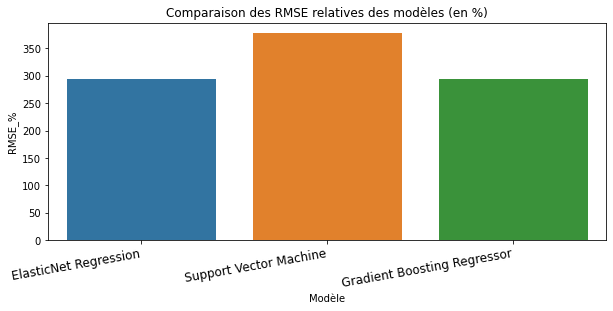

In [138]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des RMSE relatives des modèles (en %)')
chart = sns.barplot(x = results['Modèle'],
           y = results['RMSE_%']*100)
chart.set_xticklabels(labels = results['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
#ax.set_ylim([0, 5])
plt.show()

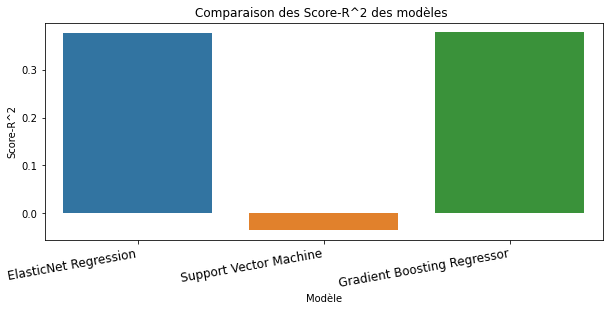

In [139]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des Score-R^2 des modèles ')
chart = sns.barplot(x = results['Modèle'],
           y = results['Score-R^2'])
chart.set_xticklabels(labels = results['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
#ax.set_ylim([0, 5])
plt.show()

In [140]:
# Sauvegarde des modèles pour log1p-SiteEnergyUse(kBtu)

dic_models_SEU1p = {
    'ElasticNet Regression': elastic_grid.best_estimator_,
    'SVM' : svm.best_estimator_,
    'Gradient Boosting Regressor' : grid_GBR.best_estimator_,
}



In [141]:
model_name = ['ElasticNet Regression', 'SVM', 'Gradient Boosting Regressor']
list_models = [dic_models_SEU1p['ElasticNet Regression'],
                 dic_models_SEU1p['SVM'],
                 dic_models_SEU1p['Gradient Boosting Regressor']]
                

In [142]:
i=0
for model in list_models:
    print(model_name[i], ': ')
    i+=1
    %timeit model.predict(X_train)
    print('')

ElasticNet Regression : 
87.4 µs ± 3.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

SVM : 
747 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Gradient Boosting Regressor : 
50.9 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)



<b> Variable target : GHGEmissions(MetricTonsCO2e) <b>

In [143]:
X.shape

(3309, 43)

In [144]:
y=df7[['GHGEmissions']]

In [145]:
type(y)

pandas.core.frame.DataFrame

In [146]:
y.isnull().sum()

GHGEmissions    0
dtype: int64

In [147]:
y.shape

(3309, 1)

In [148]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [149]:
# Algorithmes lineaires
#--------------------------------------
#regressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()]
regressors = [Lr,Rd,La,EN]

In [150]:
for model in regressors:
    start = time()
    model.fit(X_train, y_train)   # creating the model
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)    # prediction 
    predict_time = time()-start   
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.3f" % rmse)               
    print("R^2: %.3f" % r2_score(y_test, y_pred))
    print()

LinearRegression()
	Training time: 0.007s
	Prediction time: 0.000s
MSE: 92105.589
RMSE: 303.489
R^2: 0.196

Ridge(alpha=0.1)
	Training time: 0.002s
	Prediction time: 0.000s
MSE: 91694.270
RMSE: 302.811
R^2: 0.200

Lasso(alpha=0.1)
	Training time: 0.013s
	Prediction time: 0.000s
MSE: 91746.918
RMSE: 302.898
R^2: 0.199

ElasticNet(random_state=0)
	Training time: 0.002s
	Prediction time: 0.000s
MSE: 81816.213
RMSE: 286.035
R^2: 0.286



In [151]:
results1 = pd.DataFrame({})

In [152]:
# GridSearch for ElasticNet
#----------------------------
from sklearn.linear_model import ElasticNet

# Fonction de coût du Elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.01,0.001,0.0001],
              "alpha": [0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coefficient qui multiplie le terme de pénalité
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}    #L1 ratio , si L1=1 (Lasso), L1= 0  (Ridge)

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                      verbose=0
                     )

elastic_grid.fit(X_train, y_train)
y_pred=elastic_grid.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.027e+08, tolerance: 1.161e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e+08, tolerance: 8.640e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.052e+06, tolerance: 1.161e+05
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.216e+05, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.597e+08, tolerance: 1.161e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e+08, tolerance: 8.640e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e+08, tolerance: 8.640e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.844e+08, tolerance: 1.340e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e+08, tolerance: 8.640e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.653e+08, tolerance: 1.340e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.471e+08, tolerance: 1.340e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.472e+08, tolerance: 9.105e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.444e+08, tolerance: 1.294e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.784e+08, tolerance: 1.161e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

MSE: 84077.776
RMSE: 289.962
R^2: 0.266


In [153]:
elastic_grid.best_params_

{'alpha': 0.01, 'l1_ratio': 0.9, 'tol': 0.01}

In [154]:
elastic_grid.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.9, tol=0.01)

In [155]:
import math
results1 = results1.append(pd.DataFrame({
    'Modèle' : ['ElasticNet regression'],
    'Score-R^2' : [r2_score(y_test, y_pred)], 
    'Score-RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),                     
              ignore_index=True)



/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/3116794698.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results1 = results1.append(pd.DataFrame({


In [156]:
#GridSearchCV for Support Vector Machine

#----------------------------------------------------------------


parameters = {'gamma' : [1e-4, 1e-3, 1e-2], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1], #erreur tolérée par l'algorithme
              'C' : [0.01, 0.1, 1]} #parametre de régularisation



svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                   verbose=2
                     )

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)       
print("R^2: %.3f" % r2_score(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 116369.281
RMSE: 341.129
R^2: -0.015


In [157]:

import math
results1 = results1.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Score-R^2':[r2_score(y_test, y_pred)],
    'Score-RMSE' : [math.sqrt(mean_squared_error(svm.predict(X_test), y_test))]}),
    ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/762654543.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results1 = results1.append(pd.DataFrame({


In [158]:
#regressors_ens=[RFR,GBR,BR,ABR]
regressors_ens=[RFR,GBR,BR]

In [159]:
# Algorithmes ensemblistes
#------------------------------------------------------
#regressors_ens = [RandomForestRegressor(),GradientBoostingRegressor(),BaggingRegressor()]

for model in regressors_ens:
    start = time()

    model.fit(X_train, y_train)   # creating the model
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)    # prediction 
    predict_time = time()-start    
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.3f" % rmse)               
    print("R^2: %.3f" % r2_score(y_test, y_pred))
    print()

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1157081362.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)   # creating the model
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomForestRegressor(max_depth=2, random_state=0)
	Training time: 0.199s
	Prediction time: 0.004s
MSE: 80276.429
RMSE: 283.331
R^2: 0.300

GradientBoostingRegressor()
	Training time: 0.342s
	Prediction time: 0.001s
MSE: 44354.914
RMSE: 210.606
R^2: 0.613



/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(base_estimator=SVR(), random_state=0)
	Training time: 1.861s
	Prediction time: 1.705s
MSE: 112854.759
RMSE: 335.939
R^2: 0.015



In [160]:
y_test.mean()

GHGEmissions    145.452508
dtype: float64

<b> GridSearchCV of the model: <b>

In [161]:
# GridSearchCV of the model : GradientBoostingRegressor
#----------------------------------------------------------
#GBR = GradientBoostingRegressor()


parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8] 
                 }


grid_GBR = GridSearchCV(estimator=GBR, 
                        param_grid = parameters, 
                        cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)  
y_pred = grid_GBR.predict(X_test) 
grid_GBR.score(X_test, y_test)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

0.42959365014787565

In [162]:
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

MSE: 65372.394
RMSE: 255.680
R^2: 0.430


In [163]:
import math
results1 = results1.append(pd.DataFrame({
    'Modèle' : ['Gradient Boosting Regressor'],
    'Score-R^2':[r2_score(y_test, y_pred)],
    'Score-RMSE' : [math.sqrt(mean_squared_error(grid_GBR.predict(X_test), y_test))]}),
    ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1315153776.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results1 = results1.append(pd.DataFrame({


In [164]:
results1

,Modèle,Score-R^2,Score-RMSE
0,ElasticNet regression,0.266380,289.961681
1,Support Vector Machine,-0.015379,341.129420
2,Gradient Boosting Regressor,0.429594,255.680257


In [165]:
y_test.mean()

GHGEmissions    145.452508
dtype: float64

In [166]:
type(results1)

pandas.core.frame.DataFrame

In [167]:
results1['Score-RMSE']

0    289.961681
1    341.129420
2    255.680257
Name: Score-RMSE, dtype: float64

In [168]:
#results1['RMSE-%'] = results1['Score-RMSE'].divide(y_test.mean())

In [169]:
results1

,Modèle,Score-R^2,Score-RMSE
0,ElasticNet regression,0.266380,289.961681
1,Support Vector Machine,-0.015379,341.129420
2,Gradient Boosting Regressor,0.429594,255.680257


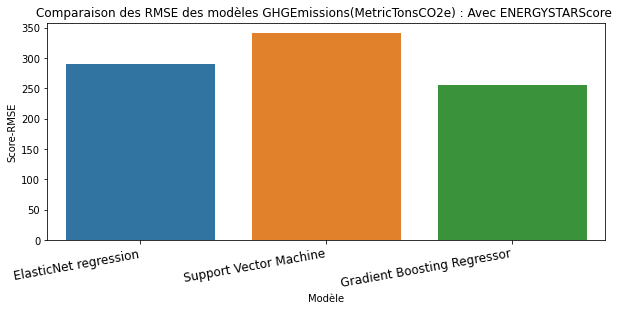

In [170]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des RMSE des modèles GHGEmissions(MetricTonsCO2e) : Avec ENERGYSTARScore ')
chart = sns.barplot(x = results1['Modèle'],y = results1['Score-RMSE'])
chart.set_xticklabels(labels = results1['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
#ax.set_ylim([0, 5])
plt.show()

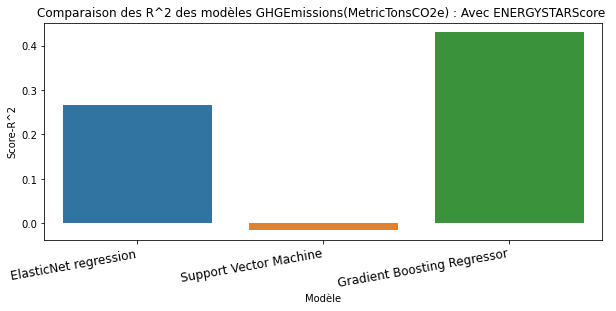

In [171]:
# R^2 score plot

plt.figure(figsize=(10,4))
plt.title('Comparaison des R^2 des modèles GHGEmissions(MetricTonsCO2e) : Avec ENERGYSTARScore ')
chart = sns.barplot(x = results1['Modèle'],y = results1['Score-R^2'])
chart.set_xticklabels(labels = results1['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
#ax.set_ylim([0, 5])
plt.show()

In [172]:
dfGBR_C = pd.DataFrame(grid_GBR.cv_results_).set_index('rank_test_score').sort_index()
dfGBR_C.shape

(81, 13)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Text(0, 0.5, 'mean_test_score')

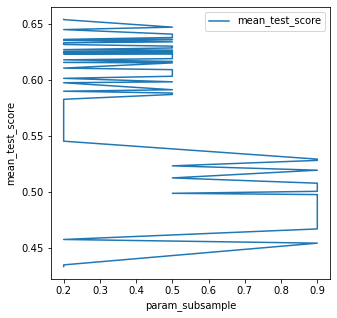

In [173]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
dfGBR_C.set_index("param_subsample")[["mean_test_score"]].plot(ax=ax)
ax.set_xlabel("param_subsample")
ax.set_ylabel("mean_test_score")

In [174]:
y_test=y_test.to_numpy()

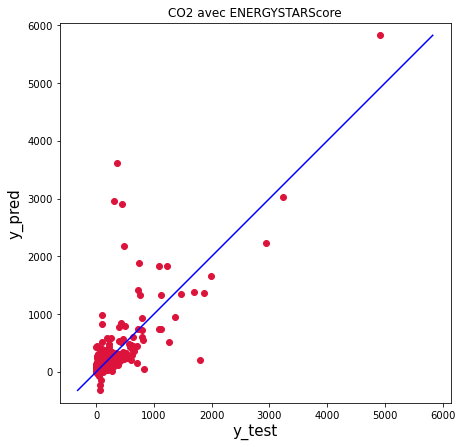

In [175]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_pred', fontsize=15)
plt.title('CO2 avec ENERGYSTARScore')
plt.axis('equal')
plt.show()

In [176]:
type(y_test)

numpy.ndarray

In [177]:
type(y_pred)

numpy.ndarray

In [178]:
# Sauvegarde des modèles pour GHGEmissions (avec ENERGYSTARScore)

dic_modelsGHG = {
    'ElasticNet Regression': elastic_grid.best_estimator_,
    'SVM' : svm.best_estimator_,
    'Gradient Boosting Regressor' : grid_GBR.best_estimator_,
}



In [179]:
model_name = ['ElasticNet Regression', 'SVM', 'Gradient Boosting Regressor']
list_models = [dic_modelsGHG['ElasticNet Regression'],
                 dic_modelsGHG['SVM'],
                 dic_modelsGHG['Gradient Boosting Regressor']]
                


In [180]:
i=0
for model in list_models:
    print(model_name[i], ': ')
    i+=1
    %timeit model.predict(X_train)
    print('')

ElasticNet Regression : 
93.8 µs ± 6.78 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

SVM : 
1.26 s ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Gradient Boosting Regressor : 
28.1 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



In [181]:
df7.head(1)

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Latitude,Longitude,PropertyGFAParking,PropertyGFABuilding,Building_age,SiteEnergyUse,GHGEmissions,Log1p-SiteEnergyUse
0,NonResidential,Hotel,1.0,12.0,65.0,47.61219,-122.337997,0.0,11.390023,88.0,6981428.0,249.43,15.758764


In [182]:
col_trans=ohe.get_feature_names()
col_trans

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_Campus', 'x0_NonResidential', 'x0_Nonresidential COS',
       'x0_Nonresidential WA', 'x0_SPS-District K-12',
       'x1_College/University', 'x1_Distribution Center',
       'x1_Distribution Center\n', 'x1_Hospital', 'x1_Hotel',
       'x1_K-12 School', 'x1_Laboratory', 'x1_Large Office',
       'x1_Low-Rise Multifamily', 'x1_Medical Office',
       'x1_Mixed Use Property', 'x1_Non-Refrigerated Warehouse',
       'x1_Office', 'x1_Other', 'x1_Refrigerated Warehouse',
       'x1_Residence Hall', 'x1_Residence Hall/Dormitory',
       'x1_Restaurant', 'x1_Restaurant\n', 'x1_Retail Store',
       'x1_SPS-District K-12', 'x1_Self-Storage Facility',
       'x1_Self-Storage Facility\n', 'x1_Senior Care Community',
       'x1_Small- and Mid-Sized Office', 'x1_Supermarket / Grocery Store',
       'x1_Supermarket/Grocery Store', 'x1_University', 'x1_Warehouse',
       'x1_Worship Facility'], dtype=object)

In [183]:
X.shape

(3309, 43)

In [184]:
col_trans.shape

(35,)

In [185]:
len(col_trans)

35

In [186]:
cols=['BuildingType', 'PrimaryPropertyType','NumberofBuildings','NumberofFloors','ENERGYSTARScore','Latitude','Longitude','PropertyGFAParking','PropertyGFABuilding','Building_age']

In [187]:
cols_new = np.concatenate((cols, col_trans))
print(cols_new)

['BuildingType' 'PrimaryPropertyType' 'NumberofBuildings' 'NumberofFloors'
 'ENERGYSTARScore' 'Latitude' 'Longitude' 'PropertyGFAParking'
 'PropertyGFABuilding' 'Building_age' 'x0_Campus' 'x0_NonResidential'
 'x0_Nonresidential COS' 'x0_Nonresidential WA' 'x0_SPS-District K-12'
 'x1_College/University' 'x1_Distribution Center'
 'x1_Distribution Center\n' 'x1_Hospital' 'x1_Hotel' 'x1_K-12 School'
 'x1_Laboratory' 'x1_Large Office' 'x1_Low-Rise Multifamily'
 'x1_Medical Office' 'x1_Mixed Use Property'
 'x1_Non-Refrigerated Warehouse' 'x1_Office' 'x1_Other'
 'x1_Refrigerated Warehouse' 'x1_Residence Hall'
 'x1_Residence Hall/Dormitory' 'x1_Restaurant' 'x1_Restaurant\n'
 'x1_Retail Store' 'x1_SPS-District K-12' 'x1_Self-Storage Facility'
 'x1_Self-Storage Facility\n' 'x1_Senior Care Community'
 'x1_Small- and Mid-Sized Office' 'x1_Supermarket / Grocery Store'
 'x1_Supermarket/Grocery Store' 'x1_University' 'x1_Warehouse'
 'x1_Worship Facility']


In [188]:
Remove=['x1_Residence Hall/Dormitory','x1_Restaurant\n']

In [189]:
type(cols_new)

numpy.ndarray

In [190]:
cols_new[33]

'x1_Restaurant\n'

In [191]:
cols_new = np.delete(cols_new, [31, 33])

In [192]:
cols_new.shape

(43,)

In [193]:
cols_new=cols_new

In [194]:
cols_new.shape

(43,)

In [195]:

X=pd.DataFrame(X, columns=cols_new)

In [196]:
X.shape

(3309, 43)

In [197]:
coefficients = abs(grid_GBR.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

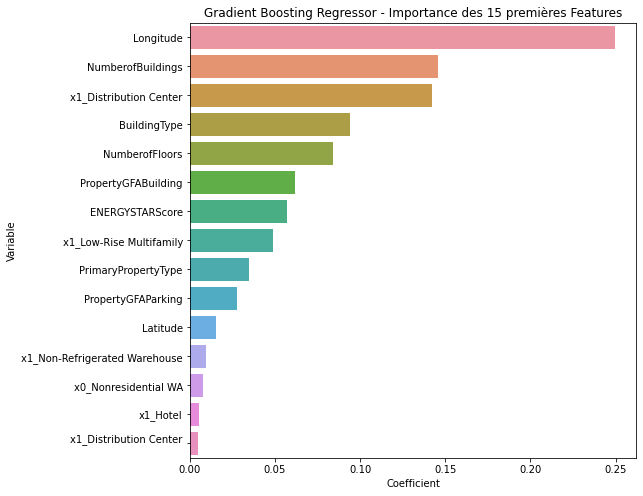

In [198]:
plt.figure(figsize=(8,8))
plt.title('Gradient Boosting Regressor - Importance des 15 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(15),
            x = liste_coefs_rer['Coefficient'].head(15))
plt.show()

In [199]:
coefficients.shape

(43,)

<b> Elimination de la variable ENERGYSTARScore :<b>

In [200]:
df7=pd.read_csv('df6.csv')

In [201]:
df7.columns

Index(['BuildingType', 'PrimaryPropertyType', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Latitude', 'Longitude',
       'PropertyGFAParking', 'PropertyGFABuilding', 'Building_age',
       'SiteEnergyUse', 'GHGEmissions', 'Log1p-SiteEnergyUse'],
      dtype='object')

In [202]:
type(df7)

pandas.core.frame.DataFrame

In [203]:
df7.drop('ENERGYSTARScore', inplace=True, axis=1)

In [204]:
type(df7)

pandas.core.frame.DataFrame

In [205]:
df7.columns

Index(['BuildingType', 'PrimaryPropertyType', 'NumberofBuildings',
       'NumberofFloors', 'Latitude', 'Longitude', 'PropertyGFAParking',
       'PropertyGFABuilding', 'Building_age', 'SiteEnergyUse', 'GHGEmissions',
       'Log1p-SiteEnergyUse'],
      dtype='object')

In [206]:
df7 = df7.dropna(subset=['SiteEnergyUse', 'GHGEmissions','Log1p-SiteEnergyUse'])

In [207]:
y=df7[['GHGEmissions']]

In [208]:
X= df7.loc[:, ~df7.columns.isin(['SiteEnergyUse', 'GHGEmissions' , 'Log1p-SiteEnergyUse'])]

In [209]:
categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(['int32','float64']).columns

In [210]:
X_scale = StandardScaler().fit_transform(X[numerical_columns].values)
X_scale[:3,:]

array([[-0.05291004,  1.19664579, -0.07861362, -0.20182857, -0.30564479,
        -0.06007658,  1.04123119],
       [-0.05291004,  1.04453058, -0.05955631, -0.012449  ,  0.03951337,
        -0.0597864 , -1.06720795],
       [-0.05291004,  5.60798687, -0.05449548, -0.18966551, -0.30564479,
         3.6677059 , -0.24216655]])

In [211]:
X_scaled = pd.DataFrame(X_scale, index=X[numerical_columns].index, columns=X[numerical_columns].columns)
X_scaled.head(2)

,NumberofBuildings,NumberofFloors,Latitude,Longitude,PropertyGFAParking,PropertyGFABuilding,Building_age
0,-0.05291,1.196646,-0.078614,-0.201829,-0.305645,-0.060077,1.041231
1,-0.05291,1.044531,-0.059556,-0.012449,0.039513,-0.059786,-1.067208


In [212]:
# Convert the dataframe X_scaled to np.array 
X_scaled=X_scaled.to_numpy()

In [213]:
ohe = OneHotEncoder(sparse=False)

# Encodage
X_encoded=ohe.fit_transform(X[categorical_columns])



In [214]:
X_encoded=X_encoded.reshape(X_encoded.shape)

In [215]:
#Concatenation
    
X = np.concatenate([X_scaled, X_encoded], axis=1)


In [216]:
# import the KNNimputer class

from sklearn.impute import KNNImputer

# create an object for KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")
X = imputer.fit_transform(X)


In [217]:
np.count_nonzero(np.isnan(X))

0

In [218]:
np.count_nonzero(np.isnan(y))

0

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<b> GridSearchCV of the models: <b>

In [220]:
results2 = pd.DataFrame({})

In [221]:
# GridSearch for ElasticNet
#----------------------------
from sklearn.linear_model import ElasticNet

# Fonction de coût du Elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.01,0.001,0.0001],
              "alpha": [0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coefficient qui multiplie le terme de pénalité
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}    #L1 ratio , si L1=1 (Lasso), L1= 0  (Ridge)

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                      verbose=0
                     )

elastic_grid.fit(X_train, y_train)
y_pred=elastic_grid.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.787e+08, tolerance: 1.161e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e+08, tolerance: 8.640e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.454e+06, tolerance: 1.161e+06
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.454e+06, tolerance: 1.161e+05
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e+08, tolerance: 8.640e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e+08, tolerance: 1.340e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.506e+08, tolerance: 9.105e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.402e+08, tolerance: 1.294e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.130e+08, tolerance: 9.105e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.217e+08, tolerance: 1.294e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.479e+08, tolerance: 9.105e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.134e+08, tolerance: 1.294e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.429e+08, tolerance: 1.294e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.772e+08, tolerance: 1.161e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

MSE: 91460.501
RMSE: 302.424
R^2: 0.202


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.711e+07, tolerance: 1.393e+07
  model = cd_fast.enet_coordinate_descent(


In [222]:
import math
results2 = results2.append(pd.DataFrame({
    'Modèle' : ['ElasticNet regression'],
    'Score-R^2':[r2_score(y_test, y_pred)],
    'Score-RMSE' : [math.sqrt(mean_squared_error(elastic_grid.predict(X_test), y_test))]}),
              ignore_index=True)



/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/1761176274.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2 = results2.append(pd.DataFrame({


In [223]:
#GridSearchCV for Support Vector Machine

#----------------------------------------------------------------


parameters = {'gamma' : [1e-4, 1e-3, 1e-2], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1], #erreur tolérée par l'algorithme
              'C' : [0.01, 0.1, 1]} #parametre de régularisation



svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,
                      scoring = 'neg_mean_squared_error',
                      cv=5,
                   verbose=2
                     )

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)       
print("R^2: %.3f" % r2_score(y_test, y_pred))

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ................C=0.01, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.01, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.01, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.01, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.01, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.01, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.01, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .................C=0.1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.001, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..................C=0.1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.01, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=0.1, epsilon=0.1, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=0.1, epsilon=0.1, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=0.1, epsilon=0.1, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...................C=1, epsilon=0.001, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.001, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.001, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....................C=1, epsilon=0.01, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.01, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.01, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....................C=1, epsilon=0.1, gamma=0.0001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......................C=1, epsilon=0.1, gamma=0.001; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.5s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .......................C=1, epsilon=0.1, gamma=0.01; total time=   0.4s


/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 119388.565
RMSE: 345.527
R^2: -0.042


In [224]:
import math
results2= results2.append(pd.DataFrame({
    'Modèle' : ['Support Vector Machine'],
    'Score-R^2':[r2_score(y_test, y_pred)],
    'Score-RMSE' : [math.sqrt(mean_squared_error(svm.predict(X_test), y_test))]}),ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/972464125.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2= results2.append(pd.DataFrame({


In [225]:
# GridSearchCV of the best model : GradientBoostingRegressor
#----------------------------------------------------------
#GBR = GradientBoostingRegressor()


parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8] 
                 }


grid_GBR = GridSearchCV(estimator=GBR, 
                        param_grid = parameters, 
                        cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)  
y_pred = grid_GBR.predict(X_test) 
grid_GBR.score(X_test, y_test)

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asus2/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.23741792089947333

In [226]:
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % rmse)   
print("R^2: %.3f" % r2_score(y_test, y_pred))

MSE: 87397.021
RMSE: 295.630
R^2: 0.237


In [227]:
import math
results2 = results2.append(pd.DataFrame({
    'Modèle' : ['Gradient Boosting Regressor'],
    'Score-R^2':[r2_score(y_test, y_pred)],
    'Score-RMSE' : [math.sqrt(mean_squared_error(grid_GBR.predict(X_test), y_test))]}),ignore_index=True)

/var/folders/27/wwsy152x0030nt23722_jnwc0000gq/T/ipykernel_3028/2368506307.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results2 = results2.append(pd.DataFrame({


In [228]:
results2

,Modèle,Score-R^2,Score-RMSE
0,ElasticNet regression,0.201962,302.424373
1,Support Vector Machine,-0.041724,345.526505
2,Gradient Boosting Regressor,0.237418,295.629872


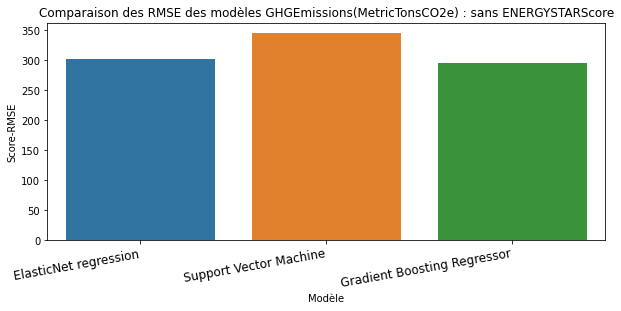

In [229]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des RMSE des modèles GHGEmissions(MetricTonsCO2e) : sans ENERGYSTARScore')
chart = sns.barplot(x = results2['Modèle'],y = results2['Score-RMSE'])
chart.set_xticklabels(labels = results2['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

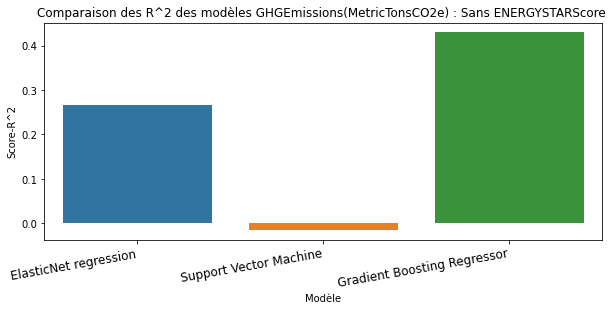

In [230]:
# R^2 score plot

plt.figure(figsize=(10,4))
plt.title('Comparaison des R^2 des modèles GHGEmissions(MetricTonsCO2e) : Sans ENERGYSTARScore ')
chart = sns.barplot(x = results2['Modèle'],y = results1['Score-R^2'])
chart.set_xticklabels(labels = results2['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
#ax.set_ylim([0, 5])
plt.show()

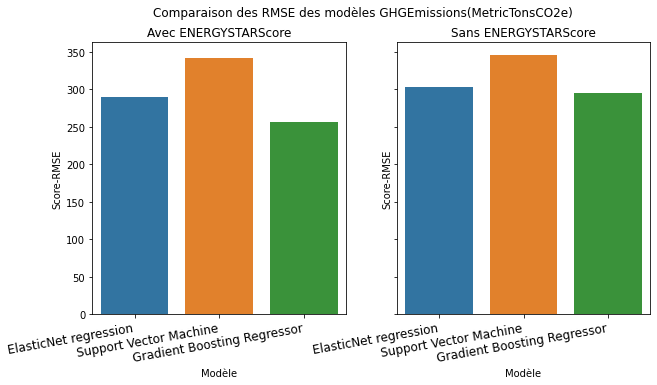

In [231]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Comparaison des RMSE des modèles GHGEmissions(MetricTonsCO2e)')

# ------------
chart = sns.barplot(ax=axes[0],x = results1['Modèle'],y = results1['Score-RMSE'])

axes[0].set_title( 'Avec ENERGYSTARScore')
chart.set_xticklabels(labels = results2['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )

# 
chart = sns.barplot(ax=axes[1],x = results2['Modèle'],y = results2['Score-RMSE'])
axes[1].set_title('Sans ENERGYSTARScore')
chart.set_xticklabels(labels = results2['Modèle'], 
                      rotation=10,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

In [232]:
y_test=y_test.to_numpy()

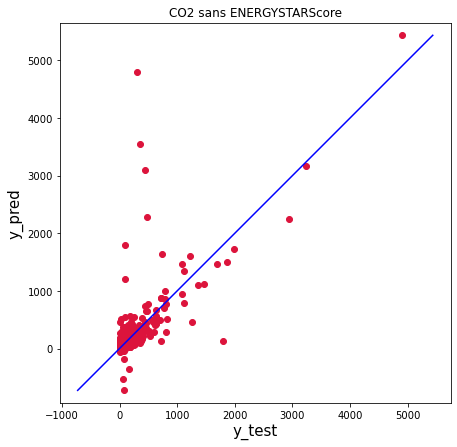

In [233]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_pred', fontsize=15)
plt.title('CO2 sans ENERGYSTARScore')
plt.axis('equal')
plt.show()

In [234]:
elastic_grid.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=0.9, tol=0.01)

In [235]:
rfr_search.best_estimator_

RandomForestRegressor(max_depth=2, min_samples_leaf=3, random_state=0)

In [236]:
svm.best_estimator_

SVR(C=1, gamma=0.01)

In [237]:
grid_GBR.best_estimator_

GradientBoostingRegressor(learning_rate=0.03, max_depth=6, n_estimators=1000,
                          subsample=0.2)

In [238]:
# Sauvegarde des modèles pour GHGEmissions (sans ENERGYSTARScore)

dic_modelsGHG_NO = {
    'ElasticNet Regression': elastic_grid.best_estimator_,
    'SVM' : svm.best_estimator_,
    'Gradient Boosting Regressor' : grid_GBR.best_estimator_,
}




In [239]:
model_name = ['ElasticNet Regression', 'SVM', 'Gradient Boosting Regressor']
list_models = [dic_modelsGHG_NO['ElasticNet Regression'],
                 dic_modelsGHG_NO['SVM'],
                 dic_modelsGHG_NO['Gradient Boosting Regressor']]
                


In [240]:
i=0
for model in list_models:
    print(model_name[i], ': ')
    i+=1
    %timeit model.predict(X_train)
    print('')

ElasticNet Regression : 
95.5 µs ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

SVM : 
1.17 s ± 84.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Gradient Boosting Regressor : 
29.3 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)



In [241]:
import pickle


# save the model to disk
filename = 'grid_GBR.sav'
pickle.dump(model, open(filename, 'wb'))
 

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.23741792089947333


In [242]:
# Conservation du meilleur modèle pour la prédiction des gaz à effet de serre
final_model= grid_GBR.best_estimator_

In [243]:
grid_GBR.best_estimator_

GradientBoostingRegressor(learning_rate=0.03, max_depth=6, n_estimators=1000,
                          subsample=0.2)